# Star Wars Dice Rolling Simulator
Original question posed as, 

    "In a game, you start with 3 dice with 8 sides (d8),
    When you upgrade, is it better change a d8 to a d12, or instead add a d6?"
    
This depends on the content of each of the sides, and what fovorable or unfavorable outcomes you are optimizing for.
Below we will be solving with a brute force method, then with pure math

# Setup

### Load packages

In [1]:
# First import librarires
# numpy will be used for our random number generator, and for quickly bucketing the histogram
# matplotlib is for plotting the histogram

import numpy as np
import math
import json
import matplotlib.pyplot as plt

### Problem Definitions

In [2]:
# Setup a default random number generator from numpy
# since no seed is specified, a random seed will be pulled fresh from the OS
rng = np.random.default_rng()

d6_dice = {
    1: "success",
    2: "success",
    3: "blank",
    4: "blank",
    5: "blank",
    6: "blank"
}

d8_dice = {
    1: "success",
    2: "success",
    3: "success",
    4: "double success",
    5: "blank",
    6: "blank",
    7: "blank",
    8: "blank"
}

d12_dice = {
    1: "success",
    2: "success",
    3: "success",
    4: "success",
    5: "success",
    6: "success",
    7: "double success",
    8: "double success",
    9: "blank",
    10: "blank",
    11: "blank",
    12: "blank"
}

dice_chooser = {
    6: d6_dice,
    8: d8_dice,
    12: d12_dice
}

roll_points = {
    "blank": 0,
    "success": 1,
    "double success": 2
}

# Brute Force: Monte Carlo

In [3]:
# Helper to roll the dice
# Will roll a set of dice 1 time
# input is: [ [number of dice type 1, number of sides of dice type 1], [..2, ..2], ... ]
# output is: a dictionary containing
#  "throws": a list containing the actual sides that were thrown for this set
#  "profile": counting up the number of times each result was found for this set
#  "score": added up points for number of total successes for this set
#  "flat_profile": a string representation of what happened this set

def roll_dice(dice_specs):
    result = {
        'throws': [],
        'score': 0,
        'profile': {
            'success': 0,
            'double success': 0,
            'blank': 0
        } 
    }
    
    for i in range(len(dice_specs)):
        n_sides = dice_specs[i][1]
        n_dice = dice_specs[i][0]
        rolls = rng.integers(low = 1, high=n_sides, size=n_dice, endpoint=True)
        
        d_dict = dice_chooser[n_sides] if n_sides in dice_chooser.keys() else print("Error, dice not found")
        
        for roll in rolls:
            outcome = d_dict[roll]
            result['profile'][outcome] += 1
            result['throws'].append(outcome)
            result['score'] += roll_points[outcome]
    
    flat_profile = [result['profile']['success'], result['profile']['double success'], result['profile']['blank']]
    result['flat_profile'] = str(result['score']) + " " + str(flat_profile)
    
    return result

In [4]:
# Let's try it out. 
# Let's roll 3d8 and 1d6
result = roll_dice([[3,8], [1,6]])
print(json.dumps(result, indent=2))


{
  "throws": [
    "blank",
    "double success",
    "success",
    "blank"
  ],
  "score": 3,
  "profile": {
    "success": 1,
    "double success": 1,
    "blank": 2
  },
  "flat_profile": "3 [1, 1, 2]"
}


In [5]:
# now let's
# 1. collect a bunch of samples,
# 2. bin the results into a histogram
# 3. organize histogram by desireable outcome

def roll_stats_descriptive( dice_specs, n_rolls = 10000):
    histo = {}
    for i in range(n_rolls):
        results = roll_dice(dice_specs)
        if results['flat_profile'] in histo.keys():
            histo[results['flat_profile']] +=1
        else:
            histo[results['flat_profile']] = 1
            
    return histo

In [6]:
histo = roll_stats_descriptive( [[3, 8], [1, 6]])
print(json.dumps(histo, indent=2, sort_keys=True))
# Note, this will get us into trouble if we ever have a score 10 or more,
#  as the sort is sorting on the string representation of the first number

{
  "0 [0, 0, 4]": 831,
  "1 [1, 0, 3]": 2266,
  "2 [0, 1, 3]": 601,
  "2 [2, 0, 2]": 2389,
  "3 [1, 1, 2]": 1271,
  "3 [3, 0, 1]": 1060,
  "4 [0, 2, 2]": 167,
  "4 [2, 1, 1]": 804,
  "4 [4, 0, 0]": 166,
  "5 [1, 2, 1]": 197,
  "5 [3, 1, 0]": 176,
  "6 [0, 3, 1]": 16,
  "6 [2, 2, 0]": 50,
  "7 [1, 3, 0]": 6
}


In [28]:
# Now let's add up probability of each score

def roll_stats( dice_specs, n_rolls = 10000, normalize=True):
    histo = {}
    for i in range(n_rolls):
        results = roll_dice(dice_specs)
        if results['score'] in histo.keys():
            histo[results['score']] +=1
        else:
            histo[results['score']] = 1
    
    possibilities = []
    for i in histo.keys():
        possibilities.append(int(i))

    labels = range(min(possibilities), max(possibilities)+1)
    values = np.zeros(len(labels), dtype = int)
    for i in histo.keys():
        values[int(i)-min(possibilities)] = histo[i]
    
    if normalize:
        values_nl = [ i/sum(values) for i in values]
        values = values_nl
    return labels, values

In [29]:
n_rolls = 50000
labels, values = roll_stats( [[3, 8], [1, 6]], n_rolls)
print(values)

[0.08238, 0.22878, 0.29752, 0.23056, 0.1155, 0.03772, 0.00692, 0.00062]


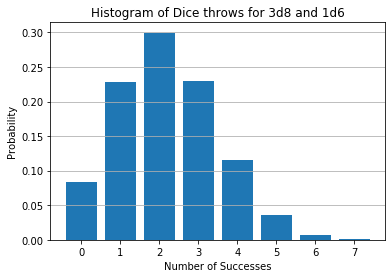

In [52]:
# Let's plot the histogram
plt.bar(labels, values)
# add some fancy display options
ax = plt.gca()
ax.set_title("Histogram of Dice throws for 3d8 and 1d6")
ax.set_xlabel("Number of Successes")
ax.set_ylabel("Probability")
ax.yaxis.grid()
plt.show()

Now we have an understanding of the probability of each numerical outcome, we really want to know how many successes this gives us in total.

To do this we can simlpy multiply the probability mass by the weight (number of successes), and then multiply this by the total number of dice throws. 

In [31]:
def gather_points(labels, values, n_rolls, normalized=True):
    sum_rolls = []
    factor = n_rolls if normalized else 1
    for i in labels:
        sum_rolls.append(i * values[i] * factor)
    
    total = sum(sum_rolls)
    return sum_rolls, total

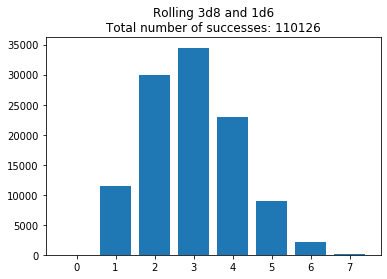

In [54]:
points, total = gather_points(labels,values, n_rolls)
plt.bar(labels, points)
plt.title("Rolling 3d8 and 1d6\nTotal number of successes: "+str(int(total)))
plt.show()

In [49]:
n_rolls = 10000
n_iter = 10
normal = []
not_normal = []
for i in range(n_iter): 
    l, v = roll_stats([[3,8]], n_rolls, normalize=False)
    s, t1 = gather_points(l, v, n_rolls, normalized=False)
    normal.append(t1)
    l, v = roll_stats([[3,8]], n_rolls, normalize=True)
    s, t2 = gather_points(l, v, n_rolls, normalized=True)
    not_normal.append(int(t2))

print("normalized")
print(normal)
print(np.mean(normal))
print(str(np.std(normal))[:6])
print("not normalized")
print(not_normal)
print(np.mean(not_normal))
print(str(np.std(not_normal))[:6])
print('difference')
print(np.mean(normal) - np.mean(not_normal))

normalized
[18789, 18727, 18559, 18529, 18695, 18711, 18730, 18749, 19057, 18606]
18715.2
139.71
not normalized
[18589, 18820, 18759, 18789, 18805, 18919, 18411, 18718, 18533, 18614]
18695.7
146.98
difference
19.5


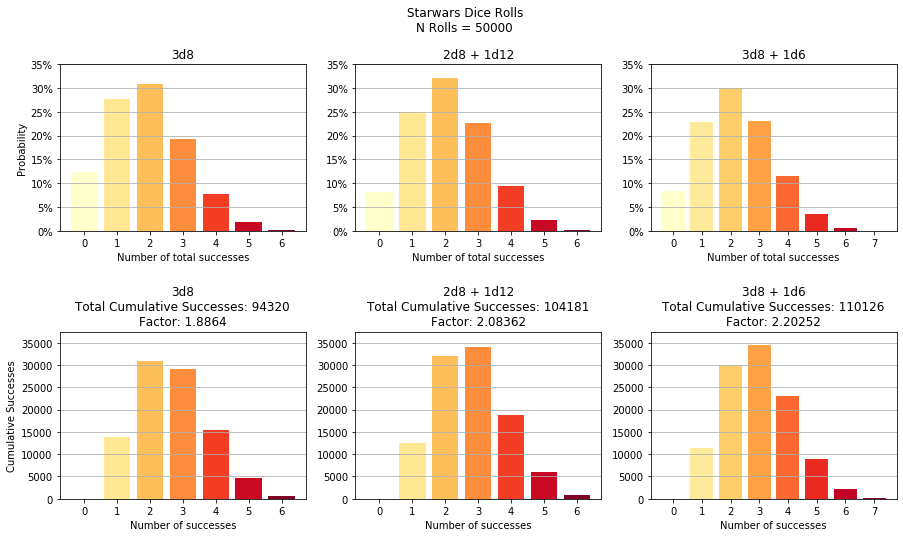

In [50]:
# Let's plot the three possibilties at once
import matplotlib.ticker as mticker

n_rolls = 50000
cm = plt.cm.get_cmap('YlOrRd')

fig, axs = plt.subplots(2,3, figsize = (15,8))
fig.suptitle("Starwars Dice Rolls\nN Rolls = "+ str(n_rolls))
fig.subplots_adjust(hspace=.6)

### 3d8 ###
labels, values = roll_stats([[3,8]], n_rolls)
colors = [ cm( label / max(labels) ) for label in labels]
i, j = 0,0
axs[i,j].bar(labels, values, color = colors)
axs[i,j].yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))
axs[i,j].yaxis.grid()
axs[i,j].set_ylim(ymax=0.35)
axs[i,j].set_title("3d8")
axs[i,j].set_xlabel("Number of total successes")
axs[i,j].set_ylabel("Probability")

i, j = 1,0
points, total = gather_points(labels, values, n_rolls)
axs[i,j].bar(labels, points, color = colors)
#axs[i,j].yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))
axs[i,j].yaxis.grid()
axs[i,j].set_ylim(ymax=(n_rolls * 0.75))
axs[i,j].set_title("3d8\nTotal Cumulative Successes: "+ str(int(total))+"\nFactor: "+ str(total / n_rolls))
axs[i,j].set_xlabel("Number of successes")
axs[i,j].set_ylabel("Cumulative Successes")


### 2d8 + 1d12 ###
labels, values = roll_stats([[2,8],[1,12]], n_rolls)
colors = [ cm( label / max(labels) ) for label in labels]
i,j = 0,1
axs[i,j].bar(labels, values, color = colors)
axs[i,j].yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))
axs[i,j].yaxis.grid()
axs[i,j].set_ylim(ymax=0.35)
axs[i,j].set_title("2d8 + 1d12")
axs[i,j].set_xlabel("Number of total successes")

i, j = 1,1
points, total = gather_points(labels, values, n_rolls)
axs[i,j].bar(labels, points, color = colors)
#axs[i,j].yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))
axs[i,j].yaxis.grid()
axs[i,j].set_ylim(ymax=(n_rolls * 0.75))
axs[i,j].set_title("2d8 + 1d12\nTotal Cumulative Successes: "+ str(int(total))+"\nFactor: "+ str(total / n_rolls))
axs[i,j].set_xlabel("Number of successes")

### 3d8 + 1d6 ##
labels, values = roll_stats([[3,8],[1,6]], n_rolls)
colors = [ cm( label / max(labels) ) for label in labels]
i,j = 0,2
axs[i,j].bar(labels, values, color = colors)
axs[i,j].yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))
axs[i,j].yaxis.grid()
axs[i,j].set_ylim(ymax=0.35)
axs[i,j].set_xticks(range(8))
axs[i,j].set_title("3d8 + 1d6")
axs[i,j].set_xlabel("Number of total successes")

i, j = 1,2
points, total = gather_points(labels, values, n_rolls)
axs[i,j].bar(labels, points, color = colors)
#axs[i,j].yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))
axs[i,j].yaxis.grid()
axs[i,j].set_ylim(ymax=(n_rolls * 0.75))
axs[i,j].set_title("3d8 + 1d6\nTotal Cumulative Successes: "+ str(int(total))+"\nFactor: "+ str(total / n_rolls))
axs[i,j].set_xlabel("Number of successes")
axs[i,j].set_xticks(range(8))

plt.show()

# Pure Math

In [51]:
# Pure math approach
# calculating probability of all posibilites of rolling d8
# raw dice side outcomes are n_sides ^ m_dice = 8^3 = 512 possible outcomes, side for side
# acutal possible outcomes are n_possiblities ^ m_dice or 3^3 = 27, but with redundancy becuase we allow replacement

# 3x success
# 3x double success
# 3x blank
# 2x success, 1x double success
# 2x success, 1x blank
# 2x double success, 1x success
# 2x double success, 1x blank
# 2x blank, 1x success
# 2x blank, 1x double success
# 1x success, 1x double success, 1x blank 

# this complicated by different weightings on the possibilities of each side

print(8*8*8)

512


In [14]:
# TODO